# predicting the sale price of bulldozers using ML

* problem definition
> how well can we predict the future sale price of its characteristics and previous examples

* data
> data is from kaggle bluebook bulldozer competition: https://www.kaggle.com/competitions/bluebook-for-bulldozers/data
Train.csv is the training set, which contains data through the end of 2011.
Valid.csv is the validation set, which contains data from January 1, 2012 - April 30, 2012. Your score on this set is used to create the public leaderboard.
Test.csv is the test set. It contains data from May 1, 2012 - November 2012. 

* evaluation
> The evaluation metric for this competition is the RMSLE (root mean squared log error) between the actual and predicted auction prices.

* features
> Data Dictionary: https://www.kaggle.com/competitions/bluebook-for-bulldozers/data?select=Data+Dictionary.xlsx


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn 

In [ ]:
#importing data and parsing date fields so they can be read
df= pd.read_csv("../data/bulldozers/TrainAndValid.csv",
                low_memory=False, 
                parse_dates=["saledate"])
df.info()
df.isna().sum()
df.SalePrice.plot.hist()
fig,ax=plt.subplots()
ax.scatter(df["saledate"][:5000],df["SalePrice"][:5000] );

In [ ]:
##Sort dataframe by saledate
#when working with time series data is good practice to sort it

df.sort_values(by=["saledate"],
               inplace=True,
               ascending=True)
dftmp=df.copy()
fig,ax=plt.subplots()
ax.scatter(dftmp["saledate"][:5000],dftmp["SalePrice"][:5000] );


In [ ]:
## Feature Engineering
# Add datetime parameters & remove "saledate" column
dftmp["saleYear"]=dftmp.saledate.dt.year
dftmp["saleMonth"]=dftmp.saledate.dt.month
dftmp["saleDay"]=dftmp.saledate.dt.day
dftmp["saleDayofWeek"]=dftmp.saledate.dt.dayofweek
dftmp["saleDayofYear"]=dftmp.saledate.dt.dayofyear
dftmp.drop("saledate", axis=1, inplace=True)


In [ ]:
#Model driven EDA

from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_jobs=-1, random_state=42)

In [ ]:
#Convert strings into categories
#One way is to convert into panda categories, documentation here: #
# https://pandas.pydata.org/pandas-docs/stable/reference/general_utility_functions.html/#data-types-related-functionality
#1-find the columns containing strings and convert them

for label, content in df.items():
    if pd.api.types.is_string_dtype(content):
        dftmp[label] = content.astype("category").cat.as_ordered()
dftmp.info()


In [ ]:
#now we have a way to access all our data in the form of numbers:
dftmp.state.cat.categories
dftmp.state.cat.codes
pd.Categorical(dftmp["state"]).codes

In [ ]:
##Fill numeric missing values

#how many null value percent do we have per column? 
dftmp.isnull().sum()/len(dftmp)
#which columns are numeric
for label, content in dftmp.items():
    if pd.api.types.is_numeric_dtype(content):
        print(label)
       
 #which have null values & fill with median
for label, content in dftmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)
            #add a binary column which tells us if the data was missing
            dftmp[label+"_missing"] = pd.isnull(content)
            #now fill
            dftmp[label] = content.fillna(content.median())
            


In [ ]:
## Filling and turning categoricals into numbers
for label, content in dftmp.items():
    if not pd.api.types.is_numeric_dtype(content):
        #add binary column to indicate whether sample had missing that value
        dftmp[label+"_missing"]=pd.isnull(content)
        #turn categories into numbers and add +1, because panda categories uses -1 as a filler over the NaNs
        dftmp[label] = pd.Categorical(content).codes + 1

In [ ]:
#how many null value percent do we have per column now? 
dftmp.isnull().sum()/len(dftmp)
dftmp.info()
dftmp.head().T

In [ ]:
#NOW we can fit the model
model=RandomForestRegressor(n_jobs=-1)
model.fit(dftmp.drop("SalePrice", axis=1), dftmp["SalePrice"])


In [ ]:
model.score(dftmp.drop("SalePrice", axis=1), dftmp["SalePrice"])

In [ ]:
#however... This set is holding the Training and validation data. For an acurate reading we need to split it correctly so:
#Validation data is the ones ran in 2012:
dftmp.saleYear.value_counts()


In [ ]:
#split it
dfval = dftmp[dftmp.saleYear == 2012]
dftrain = dftmp[dftmp.saleYear != 2012]
len(dfval), len(dftrain)

X_train, y_train = dftrain.drop("SalePrice", axis=1), dftrain.SalePrice

X_val, y_val = dfval.drop("SalePrice", axis=1), dfval.SalePrice

X_train.shape, y_train.shape, X_val.shape, y_val.shape

In [ ]:
#Building the custom evaluation function
#since the rules of the game stated to evaluate with the RMSLE, and sklearn.metrics does not include that particular one, we need to build it from:
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_log_error
#calculate the root mean squared log error between predicitons and true values
def rmsle(y_test, y_preds):
    return np.sqrt(mean_squared_log_error(y_test, y_preds))

def show_scores(model):
    train_preds=model.predict(X_train)
    val_preds=model.predict(X_val)
    scores = {"Training MAE": mean_absolute_error(y_train, train_preds),
              "Valid MAE": mean_absolute_error(y_val,val_preds),
              "Training RMSLE": rmsle(y_train, train_preds),
              "Valid RMSLE": rmsle(y_val, val_preds),
              "Trainin R2": r2_score(y_train, train_preds),
              "Valid R2": r2_score(y_val, val_preds)      
    }
    return scores

In [ ]:
#Testing our model on a subset (to tune our hyperparamenters)
#we can try with:  model.fit(X_train[:10000], y_train[:10000])
#or: 

model = RandomForestRegressor(n_jobs=-1, random_state=42, max_samples=10000)
model.fit(X_train,y_train)



In [ ]:
show_scores(model)
#If the Training MAE is higher than the Valid MAE, means we are overfitting, the other way around should be fine...

In [ ]:
#To adjust hyperparameters, we shall use the RandomizedSearchCV on RandomForest
from sklearn.model_selection import RandomizedSearchCV
rf_grid={"n_estimators":np.arange(10,100,10),
         "max_depth":[None,3,5,10],
         "min_samples_split":np.arange(2,20,2),
         "min_samples_leaf":np.arange(1,20,2),
         "max_features":[0.5,1,"sqrt"],
         "max_samples":[10000]}
rs_model=RandomizedSearchCV(RandomForestRegressor(n_jobs=-1, 
                                                  random_state=42),
                                                  param_distributions=rf_grid,
                                                  n_iter=30,
                                                  cv=5,
                                                  verbose=True)
rs_model.fit(X_train,y_train)
rs_model.best_params_
show_scores(rs_model)

In [ ]:
rs_model.best_params_

In [ ]:
show_scores(rs_model)

In [ ]:
ideal_model=RandomForestRegressor(n_jobs=-1, 
                                random_state=42,
                                n_estimators=90,
                                max_depth=None,
                                min_samples_split=6,
                                min_samples_leaf=1,
                                max_features=0.5,
                                max_samples=None)
ideal_model.fit(X_train,y_train)
show_scores(ideal_model)

In [ ]:
#NOW, the test data to make the predictions:...
df_test=pd.read_csv("../data/bulldozers/Test.csv", low_memory=False, 
                parse_dates=["saledate"])
df_test.head()

In [ ]:

#We need to adjust and manipulate everything we did to the original DataFrame (X_train) to match them two
def preprocess_data(df):
# Add datetime parameters & remove "saledate" column
    df["saleYear"]=df.saledate.dt.year
    df["saleMonth"]=df.saledate.dt.month
    df["saleDay"]=df.saledate.dt.day
    df["saleDayofWeek"]=df.saledate.dt.dayofweek
    df["saleDayofYear"]=df.saledate.dt.dayofyear
    df.drop("saledate", axis=1, inplace=True)
   #Convert strings into categories
    for label, content in df.items():
       if pd.api.types.is_string_dtype(content):
          df[label] = content.astype("category").cat.as_ordered()
    df.info()
    
    ##Fill numeric missing values
    #which have null values & fill with median
    for label, content in df.items():
        if pd.api.types.is_numeric_dtype(content):
            if pd.isnull(content).sum():
                #add a binary column which tells us if the data was missing
                df[label+"_missing"] = pd.isnull(content)
                #now fill
                df[label] = content.fillna(content.median())
                
    ## Filling and turning categoricals into numbers
        if not pd.api.types.is_numeric_dtype(content):
            #add binary column to indicate whether sample had missing that value
            df[label+"_missing"]=pd.isnull(content)
            #turn categories into numbers and add +1, because panda categories uses -1 as a filler over the NaNs
            df[label] = pd.Categorical(content).codes + 1
            
    return df


In [ ]:
df_test=preprocess_data(df_test)
df_test.head()

In [ ]:
#We can see that the df_test has only 101 columns whilst the df_train has 102...
set(X_train.columns)-set(df_test.columns)

In [ ]:
df_test['MachineHoursCurrentMeter missing', 'auctioneerID missing']=False
df_test.head()

In [97]:
#make predicitons on the test data, finally
test_preds = ideal_model.predict(df_test)

c:\Users\Mau\Downloads\PYTHON\zero-to-mastery-ml-master\venvname\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\Mau\Downloads\PYTHON\zero-to-mastery-ml-master\venvname\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [100]:
#to make this presentable, as the original competition, we shall format it:...
#https://www.kaggle.com/competitions/bluebook-for-bulldozers/overview/evaluation
df_preds = pd.DataFrame()
df_preds["SalesID"]=df_test["SalesID"]
df_preds["SalesPrice"]=test_preds
df_preds
#Export to csv
df_preds.to_csv("../data/bulldozers/test_predictions.csv")

In [118]:
#FInally, which data provided had the most relevance for our predictions...
# = Feature Importance
ideal_model.feature_importances_
#better plot it...
#Helper function to plot it
def plot_features(columns, importances):
    df=(pd.DataFrame({"features":columns,
                      "feature_importances": importances})
        .sort_values("feature_importances",
                     ascending=False)
        .reset_index(drop=True))
    fig, ax=plt.subplots()
    ax.barh(df["features"][:20], df["feature_importances"][:20])
    ax.set_ylabel("Features")
    ax.set_xlabel("Feature importance")
    ax.invert_yaxis()

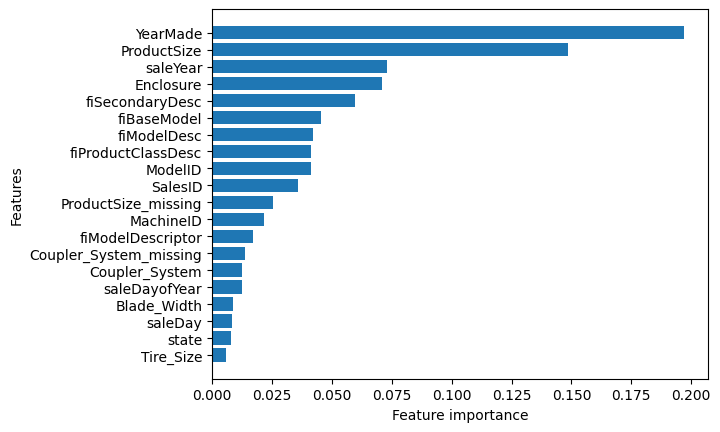

In [119]:

plot_features(X_train.columns, 
ideal_model.feature_importances_)

In [120]:
df["ProductSize"].value_counts()

Medium            2030
Large / Medium    1695
Mini               997
Small              724
Large              444
Compact            158
Name: ProductSize, dtype: int64

In [122]:
df["Enclosure"].value_counts()

OROPS         4916
EROPS w AC    4273
EROPS         3266
Name: Enclosure, dtype: int64